## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Found 8 CPU kernals, load data.....


170499072it [00:13, 12416160.89it/s]                               


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


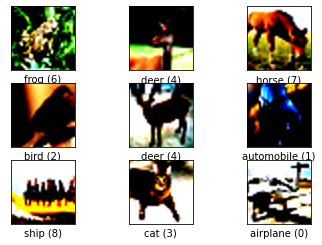

In [8]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

# check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Found CUDA device, setting copy tensors into CUDA pinned memory")
    trainloader, valloader = get_train_valid_loader(num_workers=1, pin_memory=True)
else:
    from multiprocessing import cpu_count
    print(f"Found {cpu_count()} CPU kernals, load data.....")
    trainloader, valloader = get_train_valid_loader(num_workers=cpu_count(), pin_memory=False)

Fomular
$$
\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
\sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$$
where :
- $\star$ is the valid 2D `cross-correlation`_ operator,
- `N` is a batch size,
- `C` denotes a number of channels,
- `H` is a height of input planes in pixels, 
- `W` iswidth in pixels.

Shape
- Input: $(N, C_{in}, H_{in}, W_{in})$
- Output:$(N, C_{out}, H_{out}, W_{out})$ 

where:

- $ H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor
$
- $ W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
$

In [10]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        # use the VGG11bn model which 8 convolution layers and 3 full connect layers
        # '?' denotes the batch size, which is 64 in our default setting from func above
        # network:[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        self.features = nn.Sequential(
                # 1. 64
                nn.Conv2d(3, 64, kernel_size=3, padding=1),         # (  3,32,32) => ( 64,32,32)
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),              # ( 64,32,32) => ( 64,16,16)
                # 2. 128 conv
                nn.Conv2d(64, 128, kernel_size=3, padding=1),       # ( 64,16,16) => (128,16,16)
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),              # (128,16,16) => (128, 8, 8)
                # 3. 256 conv
                nn.Conv2d(128, 256, kernel_size=3, padding=1),      # (128, 8, 8) => (256, 8, 8)
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                # 4. 256
                nn.Conv2d(256, 256, kernel_size=3, padding=1),      # (256, 8, 8) => (256, 8, 8)
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),              # (256, 8, 8) => (256, 4, 4)
                # 5. 512
                nn.Conv2d(256, 512, kernel_size=3, padding=1),      # (512, 4, 4) => (512, 4, 4)
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),                
                # 6. 512
                nn.Conv2d(512, 512, kernel_size=3, padding=1),      # (512, 4, 4) => (512, 4, 4)
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),  
                nn.MaxPool2d(kernel_size=2, stride=2),              # (512, 4, 4) => (512, 2, 2)
                # 7. 512
                nn.Conv2d(512, 512, kernel_size=3, padding=1),      # (512, 2, 2) => (512, 2, 2)
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),  
                # 8. 512
                nn.Conv2d(512, 512, kernel_size=3, padding=1),      # (512, 2, 2) => (512, 2, 2)
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),  
                nn.MaxPool2d(kernel_size=2, stride=2),              # (512, 2, 2) => (512, 1, 1)
        )
        self.classifier = nn.Sequential(
                # 9. Linear
                nn.Dropout(),
                nn.Linear(512, 512),                                # (512, 1, 1) => flatten => (512,)
                nn.ReLU(True),
                # 10. linear
                nn.Dropout(),
                nn.Linear(512, 512),                                # (512,) => (512,)
                nn.ReLU(True),
                # 11. linear
                nn.Linear(512, 10),                                 # (512,) => (10,)
        )
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [13]:
net = ConvNet()
x = torch.ones((64,3,32,32))
y = net(x)
print(y.shape)

torch.Size([64, 10])


In [ ]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

epochs = 300
steps = 0
running_loss = 0
print_every = 300
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(outputs, labels)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                with torch.no_grad():
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    # alternatively
                    # _, predicted = torch.max(F.softmax(outputs,dim=1).data, 1)
                    accuracy += (predicted == labels).sum().item() / labels.size(0)
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

### I trained the model on a HPC, this is part of the logs
Epoch: 1/300.. Loss: 2.1722.. Test accuracy: 0.2354.. 0.0564 s/batch

..........

Epoch: 1/300.. Loss: 1.5063.. Test accuracy: 0.4239.. 0.0241 s/batch

..........

Epoch: 2/300.. Loss: 1.0678.. Test accuracy: 0.6131.. 0.0228 s/batch

Epoch: 2/300.. Loss: 1.0632.. Test accuracy: 0.6143.. 0.0319 s/batch

..........

Epoch: 2/300.. Loss: 1.0336.. Test accuracy: 0.6424.. 0.0226 s/batch

...........

Epoch: 300/300.. Loss: 0.1251.. Test accuracy: 0.8190.. 0.0217 s/batch

Epoch: 300/300.. Loss: 0.1308.. Test accuracy: 0.8145.. 0.0212 s/batch

Save best trained model.

In [ ]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)
torch.save(net.state_dict(), 'drive/MyDrive/Colab Notebooks/linearClassifier_pytorch.ckpt')

In [ ]:
checkpoint = torch.load("drive/MyDrive/Colab Notebooks/linearClassifier_pytorch.ckpt")
net.load_state_dict(checkpoint)